# Preprocesses uncertainty intervals from FaIR simulations

This notebook reads in CSV files with percentiles for the temperature change in the scenarios as simulated with FaIR and then writes these to a netcdf file along.

In [28]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:

%load_ext autoreload
%autoreload 2

from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR_BADC

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [3]:
from ar6_ch6_rcmipfigs.utils.badc_csv import read_csv_badc

In [32]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR

## Define file paths

### Input:

In [30]:
fp_uncertainty = INPUT_DATA_DIR_BADC / 'slcf_warming_ranges/'

### Output:

In [31]:
PATH_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris.nc'

# Code + figures

### Read in csv files:

In [6]:


dic_ssp = {}
for f in fp_uncertainty.glob('*.csv'):
    ls_com = f.name.split('_')
    ssp = ls_com[-2]
    ssp
    perc = ls_com[-1].split('.')[0]
    if ssp not in dic_ssp.keys():
        dic_ssp[ssp] = dict()
    if perc not in dic_ssp[ssp]:
        dic_ssp[ssp][perc] = dict()

    dic_ssp[ssp][perc] = read_csv_badc(f, index_col=0)

### Various definitions

In [33]:
percentiles = ['p05', 'p16', 'p50', 'p84', 'p95']

In [34]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [35]:
dic_vars = dict(
    hfc='HFCs',
    o3='o3',
    slcf='Sum SLCF (Aerosols, Methane, Ozone, HFCs)',
    aerosol='aerosol-total',
    anthro='total_anthropogenic'
)
dic_cols = dict(
    forcing='variable',

)

### Rename variables: 

In [12]:
for s in dic_ssp.keys():
    for p in dic_ssp[s].keys():
        _df = dic_ssp[s][p]
        _df = _df.rename(dic_vars, axis=1)
        dic_ssp[s][p] = _df

In [13]:
scenario_index = scenarios_fl + [scn for scn in dic_ssp.keys() if scn not in scenarios_fl]

### Convert to dataset

In [14]:
dic_ssp_xr = dict()
ds = xr.Dataset()
for p in percentiles:
    dic_perc_xr = dict()
    for s in scenario_index:
        dic_ssp_xr[s] = dic_ssp[s][p].to_xarray()
    ls_s = [dic_ssp_xr[s] for s in scenario_index]
    _ds = xr.concat(ls_s, pd.Index(scenario_index, name='scenario'))
    _da = _ds.to_array(name=p)
    ds[p] = _da

### Open delta T dataset to plot together

In [21]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR

PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

ds_DT = xr.open_dataset(PATH_DT)

In [22]:
ds

<xarray.Dataset>
Dimensions:   (year: 81, scenario: 11, variable: 7)
Coordinates:
  * year      (year) int64 2020 2021 2022 2023 2024 ... 2096 2097 2098 2099 2100
  * scenario  (scenario) object 'ssp119' 'ssp126' 'ssp245' ... 'ssp434' 'ssp460'
  * variable  (variable) <U41 'aerosol-total' ... 'Sum SLCF (Aerosols, Methan...
Data variables:
    p05       (variable, scenario, year) float64 0.0 0.004579 ... 0.1896 0.1884
    p16       (variable, scenario, year) float64 0.0 0.006597 ... 0.2489 0.2486
    p50       (variable, scenario, year) float64 0.0 0.01013 ... 0.3623 0.3623
    p84       (variable, scenario, year) float64 0.0 0.01414 ... 0.5082 0.5091
    p95       (variable, scenario, year) float64 0.0 0.01696 ... 0.6229 0.6254

In [23]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic

# scenario colors and linestyle
cdic = get_scenario_c_dic()

<IPython.core.display.Javascript object>

hallo


### Plot data:

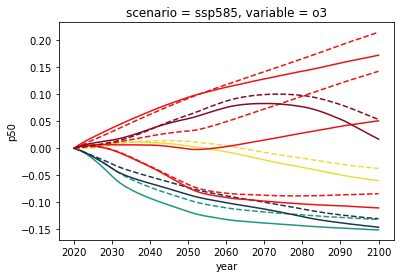

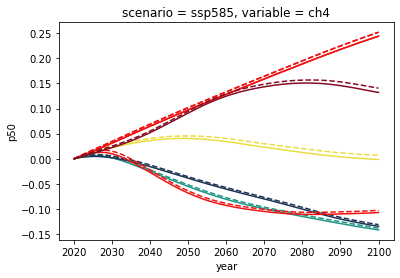

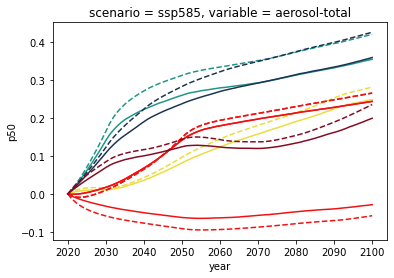

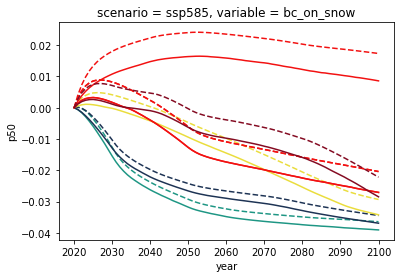

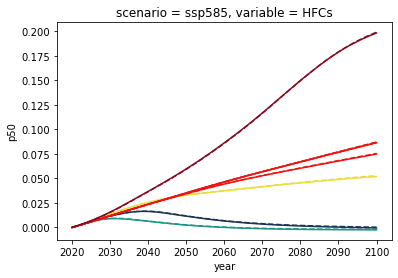

In [24]:
cdic: dict

for var in ['o3', 'ch4', 'aerosol-total', 'bc_on_snow', 'HFCs']:
    for scn in scenarios_fl:
        pl_da = ds_DT['Delta T'].sel(variable=var, year=slice(2020, 2100), scenario=scn, percentile='recommendation') - \
                ds_DT['Delta T'].sel(variable=var, year=2020, scenario=scn, percentile='recommendation')

        pl_da.plot(linestyle='dashed', label=scn, c=cdic[scn])

        pl_da = ds['p50'].sel(variable=var, year=slice(2020, 2100), scenario=scn)  # , percentile='recommendation')
        pl_da.plot(linestyle='solid', label=scn, c=cdic[scn])
    plt.show()

## Make difference between 50th percentile and others and save:

In [25]:
p50 = 'p50'
for perc in percentiles:
    nvn = f'{perc}-p50'
    ds[nvn] = ds[perc] - ds[p50]
    print(nvn)
ds

p05-p50
p16-p50
p50-p50
p84-p50
p95-p50


<xarray.Dataset>
Dimensions:   (year: 81, scenario: 11, variable: 7)
Coordinates:
  * year      (year) int64 2020 2021 2022 2023 2024 ... 2096 2097 2098 2099 2100
  * scenario  (scenario) object 'ssp119' 'ssp126' 'ssp245' ... 'ssp434' 'ssp460'
  * variable  (variable) <U41 'aerosol-total' ... 'Sum SLCF (Aerosols, Methan...
Data variables:
    p05       (variable, scenario, year) float64 0.0 0.004579 ... 0.1896 0.1884
    p16       (variable, scenario, year) float64 0.0 0.006597 ... 0.2489 0.2486
    p50       (variable, scenario, year) float64 0.0 0.01013 ... 0.3623 0.3623
    p84       (variable, scenario, year) float64 0.0 0.01414 ... 0.5082 0.5091
    p95       (variable, scenario, year) float64 0.0 0.01696 ... 0.6229 0.6254
    p05-p50   (variable, scenario, year) float64 0.0 -0.005551 ... -0.1739
    p16-p50   (variable, scenario, year) float64 0.0 -0.003533 ... -0.1137
    p50-p50   (variable, scenario, year) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    p84-p50   (variable, scenario, year) float64 0.0 0.004012 ... 0.1459 0.1468
    p95-p50   (variable, scenario, year) float64 0.0 0.006826 ... 0.2606 0.2631

In [26]:
PATH_DT_OUTPUT

PosixPath('/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_uncertainty_data_FaIR_chris.nc')

In [27]:
ds.to_netcdf(PATH_DT_OUTPUT)